# Section 5: Table 3 and Figure 3 (a)-(g)

In [1]:
import pandas as pd
import numpy as np

INPUT_PATH = "../data/bpm_25/8fts_3miners_ind_ilp_sm1_shapley.csv"
METRIC_ORDER = ["fitness", "precision", "fscore","cfc", "size", "exectime"]

In [2]:
data = pd.read_csv(INPUT_PATH)
absolute_data = data.copy()
absolute_data["shapley_value"] = absolute_data["shapley_value"].abs()

summary = absolute_data.groupby(["metric", "feature_name"])["shapley_value"].mean().unstack()
metric_order = ["fitness", "precision", "fscore", "cfc", "size", "exectime"]

summary = summary.reindex(metric_order)

summary_normalized = summary.div(summary.sum(axis=1), axis=0)
summary_normalized = summary_normalized.round(2)

summary_normalized["mean"] = summary_normalized.mean(axis=1)
summary_normalized = summary_normalized.sort_values("mean", ascending=False)

metric_order = METRIC_ORDER
summary_normalized = summary_normalized.reindex(metric_order)
summary_normalized = summary_normalized.round(2)
#print(summary_normalized)

# Ranking most impacted metrics
## Table 3: 
### Mean Shapley values and standard deviation of normalized values across evaluation metrics, ordered by feature impact variability.

In [3]:
# Assuming 'data' is already loaded
metric_order = METRIC_ORDER

# Calculate mean Shapley values per metric and feature, then reorder metrics
summary = data.groupby(["metric", "feature_name"])["shapley_value"].mean().unstack().reindex(metric_order)

# Calculate mean of Shapley values, normalize, and calculate norm_mean and std
summary_normalized = summary.div(summary.sum(axis=1), axis=0).round(2)
summary['mean'] = summary.mean(axis=1).round(2)
summary_normalized['norm_mean'] = summary_normalized.mean(axis=1).round(2)

# Calculate std and create final table
summary_normalized['std'] = summary_normalized.drop(columns=['norm_mean']).std(axis=1).round(2)
final_table = summary_normalized[['norm_mean', 'std']].assign(mean=summary['mean'])

# Reorganize and print final table
final_table = final_table[['mean', 'std']]
final_table = final_table.sort_values(by=['std'], ascending=False)

final_table.transpose()

metric,cfc,size,exectime,precision,fscore,fitness
feature_name,,,,,,
mean,2.52,7.40,2.69,0.26,0.28,0.32
std,0.11,0.08,0.06,0.03,0.03,0.01


# Ranking features per feature impact on metrics
## Figure 3 (a): Overall feature impact ranking per metric

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define FONTSIZE constant for consistent font size across the plot
FONTSIZE = 38

def plot_feature_impact(data, title_suffix):
    """
    This function generates a plot of feature impact rankings across various metrics.

    Parameters:
    - data: DataFrame containing the data with Shapley values.
    - title_suffix: A string that will be appended to the plot title.
    """
    # Compute mean Shapley values per metric and feature
    summary = data.groupby(["metric", "feature_name"])["shapley_value"].mean().unstack()

    # Define metric order and rename metrics
    metric_order = ["fitness", "precision", "fscore", "size", "cfc", "exectime"]
    summary = summary.reindex(metric_order)

    # Round for readability
    summary = summary.round(2)

    # Normalize the values for stacking
    summary_normalized = summary.div(summary.sum(axis=1), axis=0)

    # Create a mapping of feature colors (same color per feature across all metrics)
    feature_colors = plt.cm.get_cmap("tab10", len(summary.columns))
    feature_color_mapping = {feature: feature_colors(i) for i, feature in enumerate(summary.columns)}

    # Create subplots for each metric
    fig, axes = plt.subplots(1, len(summary.index), figsize=(1 * len(metric_order), 11), facecolor='white')

    # If there is only one metric, axes will not be an array, so handle that case
    if len(summary.index) == 1:
        axes = [axes]

    # Plot each metric in a separate subplot
    for i, (metric, ax) in enumerate(zip(summary.index, axes)):
        # Rename metrics for more clarity
        if metric == "exectime":
            metric_title = "Exec. Time"
        elif metric == "fscore":
            metric_title = "F-Score"
        elif metric == "cfc":
            metric_title = "CFC"
        else:
            metric_title = metric.capitalize()

        # Get the non-normalized (absolute) values for the current metric
        non_normalized_values = summary.loc[metric]

        # Sort the features based on non-normalized values (highest to lowest)
        sorted_features = non_normalized_values.sort_values(ascending=False).index
        sorted_non_normalized_values = non_normalized_values[sorted_features]

        # Normalize the sorted values for stacking
        sorted_summary_normalized = summary_normalized.loc[metric, sorted_features]

        # Keep track of the bottom position for stacking each segment
        bottoms = np.zeros(len(sorted_summary_normalized))
        if metric == metric_order[0]:
            legend_order = sorted_summary_normalized.index
        # Plot each feature for the current metric in the sorted order
        for feature_idx, feature in enumerate(sorted_summary_normalized.index):
            ax.bar(metric, sorted_summary_normalized[feature], bottom=bottoms[0],
                   label=feature, color=feature_color_mapping[feature])
            bottoms += sorted_summary_normalized[feature]  # Update bottom positions for the next feature

        # Annotate with non-normalized values
        """
        bottom = 0
        for feature in sorted_summary_normalized.index:
            value = sorted_non_normalized_values[feature]  # Get original (non-normalized) value
            value = sorted_summary_normalized[feature]  # Get original (non-normalized) value
            normalized_value = sorted_summary_normalized[feature]

            # Add text annotation at the center of each segment
            ax.text(0, bottom + normalized_value / 2, f"{value:.2f}",
                    ha="center", va="center", color="black", fontsize=FONTSIZE - 12)
            bottom += normalized_value
        """

        # Set labels for each subplot
        if "Across" in title_suffix:
            ax.set_ylabel("Mean Normalized |Shapley Value|", fontsize=FONTSIZE - 6)
            # Set the y-axis ticks size
            #ax.set_yticks([])
            ax.tick_params(axis='y', labelsize=FONTSIZE - 14)
        else:
            ax.set_yticks([])

        
        # Set the x-axis label to the metric title
        ax.set_xlabel(metric_title, fontsize=FONTSIZE - 10, rotation=-70, loc='left')
        # Hide x-axis ticks, as we're just showing one bar per metric
        ax.set_xticks([])

        # Show y-axis label and ticks only on the first subplot
        if i != 0:
            ax.set_ylabel('')
            ax.set_yticks([])

        # Remove subplot frame (spines)
        for spine in ax.spines.values():
            spine.set_visible(False)


    # Set a common legend and increase its size
    if "IND" in title_suffix:
        fig.legend(legend_order, title="Feature", bbox_to_anchor=(1, 0.95), loc="upper left",
                   fontsize=FONTSIZE - 10, title_fontsize=FONTSIZE - 8, frameon=False)

    # Adjust layout for better spacing and vertical space between subplots
    plt.subplots_adjust(hspace=0.3)
    
    # Use suptitle to center the main title
    #fig.suptitle(f"Ranking Features {title_suffix}", fontsize=FONTSIZE, ha="center", va="top")

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Example usage:
# data = pd.read_csv('path_to_your_data.csv')
#plot_feature_impact(absolute_data, "Across PD Algorithms")

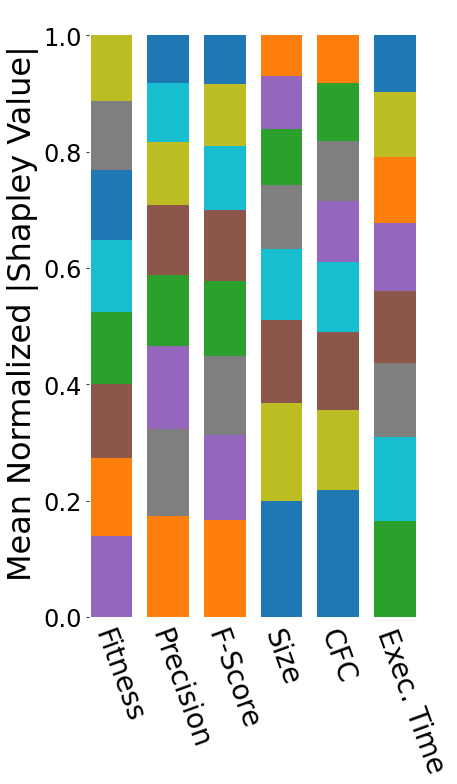

In [5]:
import pandas as pd

data = pd.read_csv(INPUT_PATH)
absolute_data = data.copy()
absolute_data["shapley_value"] = absolute_data["shapley_value"].abs()

summary = absolute_data.groupby(["metric", "feature_name"])["shapley_value"].mean().unstack()
metric_order = ["fitness", "precision", "fscore", "cfc", "size", "exectime"]

summary = summary.reindex(metric_order)

summary_normalized = summary.div(summary.sum(axis=1), axis=0)
summary_normalized = summary_normalized.round(2)

summary_normalized["mean"] = summary_normalized.mean(axis=1)
summary_normalized = summary_normalized.sort_values("mean", ascending=False)

metric_order = METRIC_ORDER
summary_normalized = summary_normalized.reindex(metric_order)
summary_normalized = summary_normalized.round(2)
#print(summary_normalized)
plot_feature_impact(absolute_data, "Across PD Algorithms")  # Add any title suffix as required

## Figure 3 (b)-(g): Overall feature impact ranking per metric
### grouped by Metric

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define FONTSIZE constant for consistent font size across the plot
FONTSIZE = 38

def plot_metric_impact(data, metric_to_plot, title_suffix):
    """
    This function generates a plot of feature impact rankings for a specific metric across algorithms.

    Parameters:
    - data: DataFrame containing the data with Shapley values.
    - metric_to_plot: The metric to plot (e.g., "fitness", "precision", etc.).
    - title_suffix: A string that will be appended to the plot title.
    """
    # Filter data for the selected metric
    filtered_data = data[data["metric"] == metric_to_plot]

    # Compute mean Shapley values per algorithm and feature for the selected metric
    summary = filtered_data.groupby(["algorithm", "feature_name"])["shapley_value"].mean().unstack()

    algorithm_order = ["sm1", "ilp", "inductive"]
    summary = summary.reindex(algorithm_order).fillna(0)  # Fill NaN with 0 if any algorithm is missing

    # Round for readability
    summary = summary.round(2)

    # Normalize the values for stacking
    summary_normalized = summary.div(summary.sum(axis=1), axis=0)

    # Create a mapping of feature colors (same color per feature across all algorithms)
    feature_colors = plt.cm.get_cmap("tab10", len(summary.columns))
    feature_color_mapping = {feature: feature_colors(i) for i, feature in enumerate(summary.columns)}

    # Create a single subplot for the selected metric
    fig, ax = plt.subplots(figsize=(4, 11), facecolor='white')

    # Plot each algorithm's stacked bar
    for i, algorithm in enumerate(summary.index):
        # Get the non-normalized (absolute) values for the current algorithm
        non_normalized_values = summary.loc[algorithm]

        # Sort the features based on non-normalized values (highest to lowest)
        sorted_features = non_normalized_values.sort_values(ascending=False).index
        sorted_non_normalized_values = non_normalized_values[sorted_features]

        # Normalize the sorted values for stacking
        sorted_summary_normalized = summary_normalized.loc[algorithm, sorted_features]

        # Keep track of the bottom position for stacking each segment
        bottoms = np.zeros(len(sorted_summary_normalized))
        if i == 0:
            legend_order = sorted_summary_normalized.index

        # Plot each feature for the current algorithm in the sorted order
        for feature_idx, feature in enumerate(sorted_summary_normalized.index):
            ax.bar(i, sorted_summary_normalized[feature], bottom=bottoms[0],
                   label=feature, color=feature_color_mapping[feature])
            bottoms += sorted_summary_normalized[feature]  # Update bottom positions for the next feature

    # Define a mapping for renaming x-axis labels
    label_mapping = {
        "inductive": "ind",
        "sm1": "sm"
    }

    # Replace algorithm names in the summary index using the mapping
    new_labels = [label_mapping.get(alg, alg) for alg in summary.index]

    # Set x-axis labels to algorithm names (with replacements)
    ax.set_xticks(range(len(summary.index)))
    ax.set_xticklabels(new_labels, fontsize=FONTSIZE, rotation=-70, ha='left')

    # Set y-axis label
    if "fitnesss"==metric_to_plot:
        ax.set_ylabel("Mean Normalized |Shapley Value|", fontsize=FONTSIZE - 6)
        ax.tick_params(axis='y', labelsize=FONTSIZE - 14)
    else:
        ax.set_yticks([])

    # Remove subplot frame (spines)
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Set a common legend and increase its size
    if "exectime"==metric_to_plot:
        fig.legend(legend_order, title="Feature", bbox_to_anchor=(1, 0.95), loc="upper left",
                   fontsize=FONTSIZE, title_fontsize=FONTSIZE, frameon=False)

    # Use suptitle to center the main title
    #fig.suptitle(f"Feature Impact for {metric_to_plot.capitalize()} {title_suffix}", fontsize=FONTSIZE, ha="center", va="top")

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Example usage:
# data = pd.read_csv('path_to_your_data.csv')
#plot_metric_impact(absolute_data, "fitness", "Across PD Algorithms")

fitness


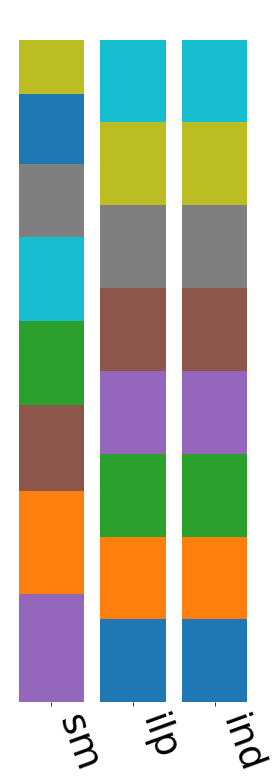

precision


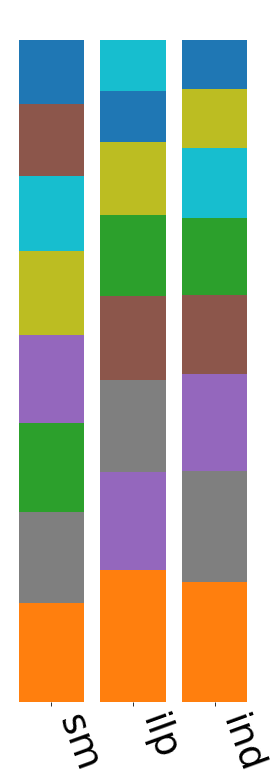

fscore


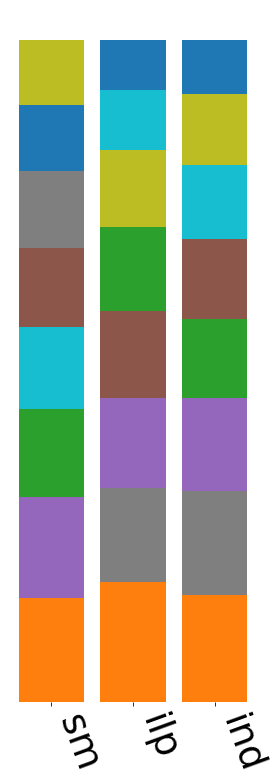

cfc


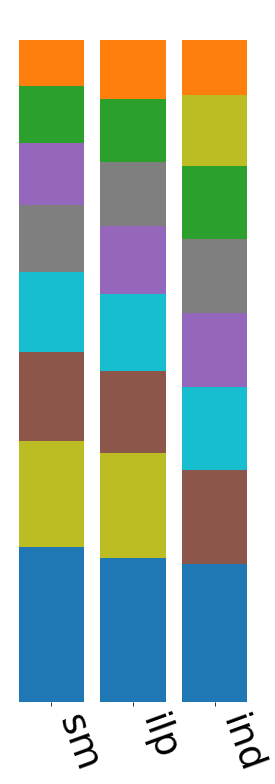

size


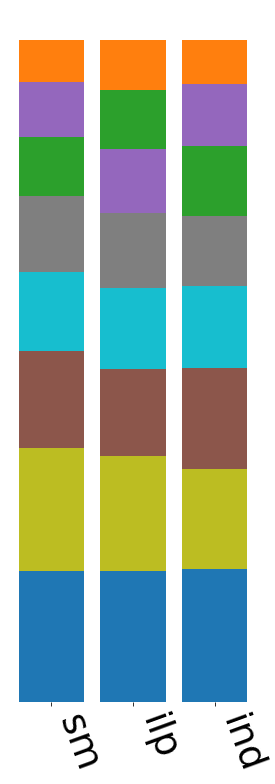

exectime


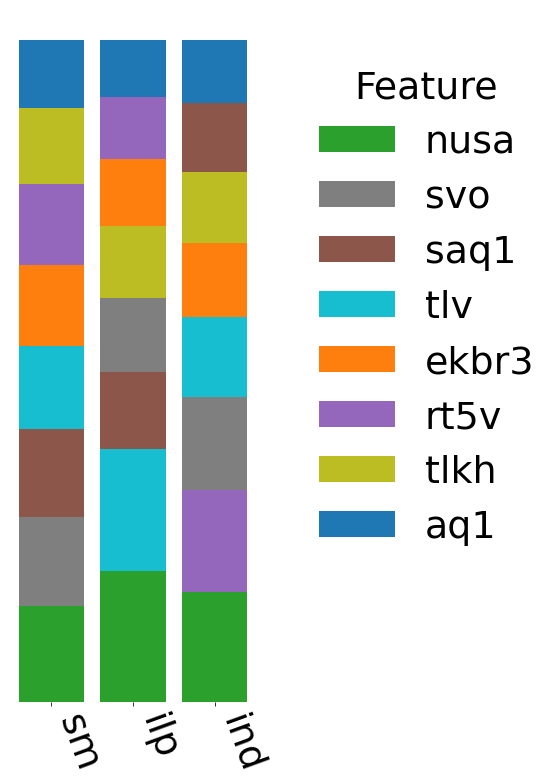

In [7]:
data = pd.read_csv(INPUT_PATH)
absolute_data = data.copy()
absolute_data["shapley_value"] = absolute_data["shapley_value"].abs()

summary = absolute_data.groupby(["metric", "feature_name"])["shapley_value"].mean().unstack()
metric_order = ["fitness", "precision", "fscore", "cfc", "size", "exectime"]

summary = summary.reindex(metric_order)

summary_normalized = summary.div(summary.sum(axis=1), axis=0)
summary_normalized = summary_normalized.round(2)

summary_normalized["mean"] = summary_normalized.mean(axis=1)
summary_normalized = summary_normalized.sort_values("mean", ascending=False)

metric_order = METRIC_ORDER
summary_normalized = summary_normalized.reindex(metric_order)
summary_normalized = summary_normalized.round(2)

for metric in metric_order:
    print(metric)
    plot_metric_impact(absolute_data, metric, "Across PD Algorithms")

## Figure 3 (b)-(d): Feature impact ranking per metric and process discovery algorithm (grouped by miner)
### ILP miner

ilp


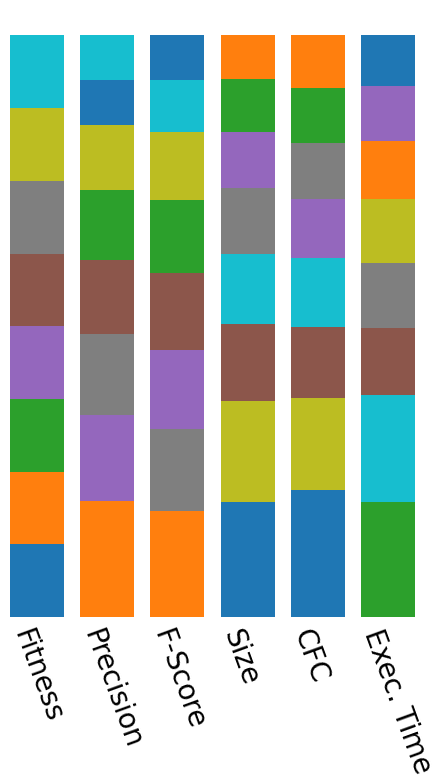

In [8]:
miner = "ilp"
data = pd.read_csv(INPUT_PATH)
data["shapley_value"] = data["shapley_value"].abs()

data = data[data["algorithm"] == miner]
print(f"{miner}")

summary = data.groupby(["metric", "feature_name"])["shapley_value"].mean().unstack()
summary["mean"] = summary.mean(axis=1)
summary = summary.round(2)
summary = summary.sort_values("mean", ascending=False)
metric_order = METRIC_ORDER
summary = summary.reindex(metric_order)
(summary)
plot_feature_impact(data, "for ILP")

# Inductive miner

inductive
feature_name    aq1  ekbr3  nusa  rt5v   saq1   svo   tlkh   tlv  mean
metric                                                                
fitness        0.33   0.33  0.33  0.33   0.33  0.33   0.33  0.33  0.33
precision      0.17   0.41  0.26  0.33   0.27  0.38   0.20  0.24  0.28
fscore         0.20   0.39  0.29  0.34   0.29  0.38   0.26  0.27  0.30
cfc            7.78   3.11  4.12  4.19   5.32  4.15   4.03  4.66  4.67
size          15.11   5.02  7.94  7.04  11.38  8.02  11.41  9.32  9.41
exectime       1.66   1.93  2.87  2.66   1.80  2.45   1.85  2.08  2.16


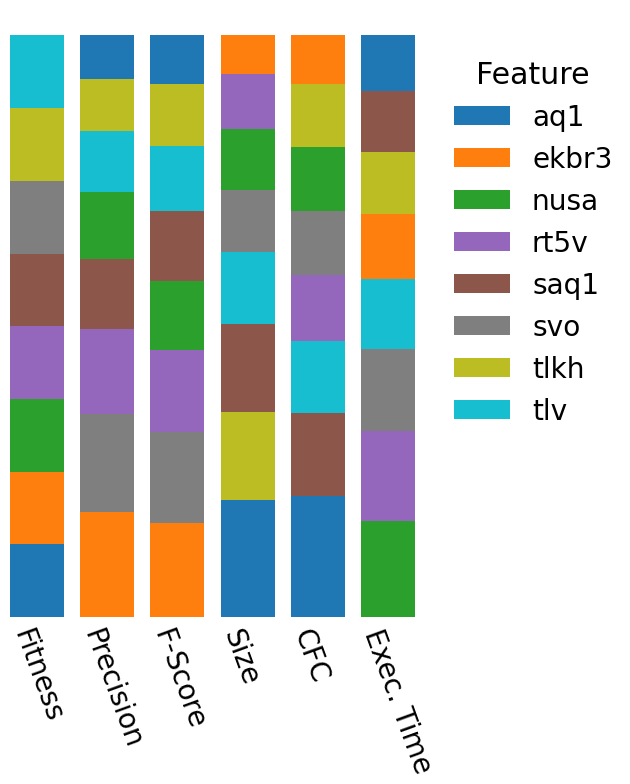

In [9]:
miner = "inductive"
data = pd.read_csv(INPUT_PATH)
data["shapley_value"] = data["shapley_value"].abs()

data = data[data["algorithm"] == miner]
print(f"{miner}")

summary = data.groupby(["metric", "feature_name"])["shapley_value"].mean().unstack()
summary["mean"] = summary.mean(axis=1)
summary = summary.round(2)
summary = summary.sort_values("mean", ascending=False)
metric_order = METRIC_ORDER
summary = summary.reindex(metric_order)
print(summary)
plot_feature_impact(data, "for IND")

## Split miner

sm1
feature_name    aq1  ekbr3  nusa  rt5v  saq1   svo   tlkh   tlv  mean
metric                                                               
fitness        0.26   0.38  0.31  0.40  0.32  0.27   0.20  0.31  0.31
precision      0.24   0.37  0.33  0.33  0.27  0.34   0.31  0.28  0.31
fscore         0.24   0.38  0.32  0.37  0.29  0.28   0.24  0.30  0.30
cfc            5.46   1.65  1.99  2.19  3.12  2.36   3.76  2.84  2.92
size          12.19   3.92  5.52  5.15  9.06  7.02  11.43  7.34  7.70
exectime       5.40   6.35  7.55  6.30  6.93  6.95   5.98  6.57  6.50


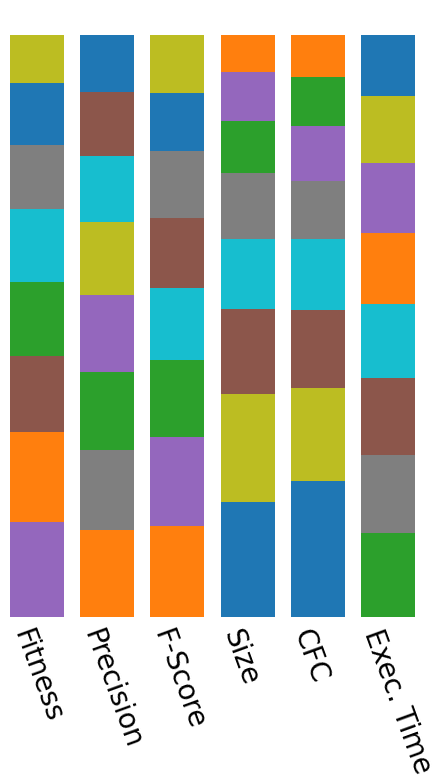

In [10]:
miner = "sm1"
data = pd.read_csv(INPUT_PATH)
data["shapley_value"] = data["shapley_value"].abs()

data = data[data["algorithm"] == miner]
print(f"{miner}")

summary = data.groupby(["metric", "feature_name"])["shapley_value"].mean().unstack()
summary["mean"] = summary.mean(axis=1)
summary = summary.round(2)
summary = summary.sort_values("mean", ascending=False)
metric_order = METRIC_ORDER
summary = summary.reindex(metric_order)
print(summary)
plot_feature_impact(data, "for SPM")